# NEU502B Homework 3: Drift-diffusion models
*Due March 20, 2024*

*Submission instructions:* First, rename your homework notebook to include your name (e.g. `homework-3-nastase.ipynb`); keep your homework notebook in the `homework` directory of your clone of the class repository. Prior to submitting, restart the kernel and run all cells (see *Kernel* > *Restart Kernel and Run All Cells...*) to make sure your code runs and the figures render properly. Only include cells with necessary code or answers; don't include extra cells used for troubleshooting. To submit, `git add`, `git commit`, and `git push` your homework to your fork of the class repository, then make a pull request on GitHub to sync your homework into the class repository.

The **drift-diffusion model** (DDM) has been a dominant model in understanding how decisions are made. The model predicts how one makes a decision by integrating evidence over time. Part of the power of the drift-diffusion model is how simple it is. The dynamics are captured by:
$$ dC = v \cdot dt + w \cdot \mathcal{N}(0,1) $$
Where $C$ is your decision variable, $v$ is the evidence that accumulates over time (the "drift"), and $w$ is the amount of noise in the integration (the "diffusion"). The initial condition is typically set to $C_0$ = 0 and the integration occurs to some bound $\pm B$, which initiates the choice. To get a better intuition for how the model works, let’s simulate a decision process using the drift-diffusion model.

In [212]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore", "is_categorical_dtype")
warnings.filterwarnings("ignore", "use_inf_as_na")

### Problem 1: Simulate a simple decision process
First, we'll simulate a simple two-alternative forced choice (2AFC) decision process using the drift-diffusion model. The following function takes in evidence $v$ and uses a `while` loop to continue updating the decision variable $C$ until it reaches either the positive or negative decision bound $\pm B$ (with random-normal noise scaled $w$ at each update). Make sure you understand what each line of the function is doing. We'll start with parameters $C_0$ = 0, $B$ = 1, $dt$ = 0.0005 ms, $v$ = 2.5, and $w$ = 0.05.

In [2]:
def ddm(C, v, dt, w, B):
    '''Simulate drift-diffusion model dynamics.

    Parameters
    ----------
    C : float
        Decision variable.
    v : float
        Drift rate.
    dt : float
        Time step (in ms).
    w : float
        Drift noise.
    B : float
        Decision bound.

    Returns
    -------
    C : float
        Decision variable at bound.
    z : float
        Reaction time (in ms)
    x : ndarray
        Accumulated evidence.
    '''

    # While decision variable C is within decision boundary,
    # update C according to the provided equation
    x = []
    while np.abs(C) < B:
        C = C + v * dt + w * np.random.randn()
        x.append(C)
    C = B if C > 0 else -B
    return C, len(x), np.array(x)

Try running 1000 simulations to get a good sense of how the model behaves. Keep the same parameters so that the only thing that differs across iterations is the noise. With positive evidence $v$ = 2.5, the "correct" choice is made when the model reaches the positive bound $B$ = 1; if the model reaches the negative bound, this indicates an "incorrect" choice. Plot the time series of accumulated evidence for several model runs (e.g. 10) to include both correct and incorrect trials. Plot model runs that terminate in a correct decision in one color, and model runs that terminate in an incorrect decision in another color. Why does the model occasionally make decision errors?

_The occasional errors the model makes is due to the accumulation of random noise (i.e., drift) at each time step. This drift results in fluctuations in the decision variable._

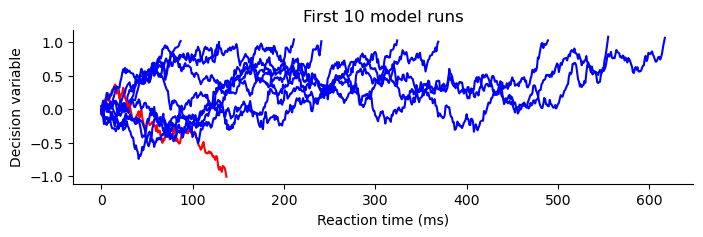

In [283]:
# Set a random seed
np.random.seed(1312)

# Set parameters
C0, v, dt, w, B = 0., 2.5, 5e-4, .05, 1.

# Loop through 1000 runs of the model:
runs = [ddm(C0, v, dt, w, B) for _ in range(1000)]
df = pd.DataFrame(runs, columns=('C', 'z', 'x'))

# Plot first e.g. 10 model runs:
plt.figure(figsize=(8, 2))
decision_to_color = {-1.0: 'r', 1.0: 'b'}
for i in range(10):
    C, z, x = df.iloc[i]
    plt.plot(np.arange(z), x, color=decision_to_color[C])
plt.xlabel('Reaction time (ms)')
plt.ylabel('Decision variable')
plt.title('First 10 model runs')
sns.despine()
plt.show()

Plot the proportion of runs that ended in correct and incorrect choices (e.g. a simple bar plot).

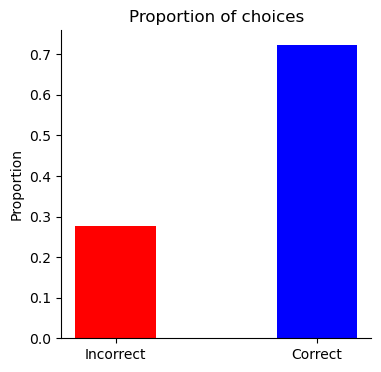

In [281]:
# Plot the proportion of correct and incorrect choices:

plt.figure(figsize=(4, 4))
x, y = np.unique(df.C, return_counts=True)
y = y / y.sum()
plt.bar(x, y, color=['r', 'b'])
plt.xticks(x, ['Incorrect', 'Correct'])
plt.ylabel('Proportion')
plt.title('Proportion of choices')
sns.despine()
plt.show()

Plot the two distributions of reaction times (RTs; e.g. using `sns.histplot` or `sns.kdeplot`) for correct and incorrect trials. (You may want to convert the reaction times and outcomes to a `pandas` `DataFrame` before plotting with `seaborn`.) Report the mean and median of these distributions. Are they symmetric or skewed?

_These distributions have a right skew._

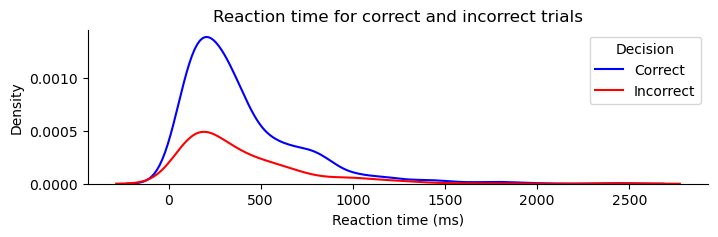

In [284]:
# Plot RT distributions of correct and incorrect trials:
plt.figure(figsize=(8, 2))
sns.kdeplot(df, x='z', hue='C', hue_order=[-1.0, 1.0], palette=['r', 'b'])
plt.xlabel('Reaction time (ms)')
plt.title('Reaction time for correct and incorrect trials')
plt.legend(title="Decision", labels=['Correct', 'Incorrect'])
sns.despine()
plt.show()

In [285]:
from scipy.stats import skew

# Report the mean, median, and skew:
df[['C', 'z']].groupby('C').agg(['mean', 'median', skew])

z                 
            mean median      skew
C                                
-1.0  387.859206  290.0  2.086342
 1.0  389.413555  297.0  1.960934

### Problem 2: Varying sensory evidence
Now that we have a grasp on how the drift-diffusion model behaves, let's start varying the input. Start with the previous model with evidence $v$ = 2.5, then run two additional models with increased $2 \times v$ evidence and decreased $.5 \times v$ evidence. As in the previous exercises, plot a few model runs, the proportion of correct and incorrect trials, and the reaction time distributions for all three levels of sensory evidence (baseline, increased, and decreased). How do these different amounts of sensory evidence affect the decision process?

_An increase in sensory evidence corresponds to an increase in decision accuracy._

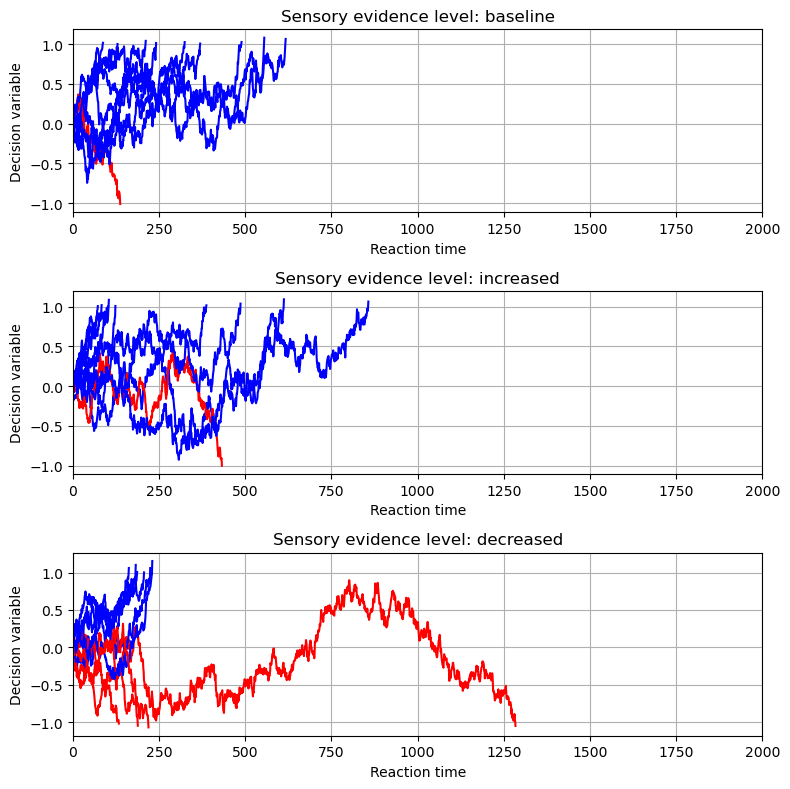

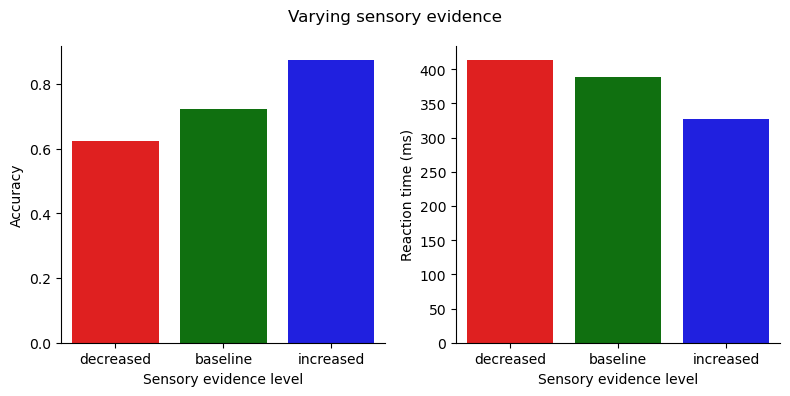

In [359]:
# Set a random seed
np.random.seed(1312)

# Set up different evidence levels
C0, dt, w, B = 0., 5e-4, .05, 1.
v_base = 2.5
vs = [v_base, v * 2, v * .5]
labels = ['baseline', 'increased', 'decreased']

# Run models and plot for three evidence levels:
runs = [(label, *ddm(C0, v, dt, w, B)) for label, v in zip(labels, vs) for _ in range(1000)]
df = pd.DataFrame(runs, columns=('label', 'C', 'z', 'x'))

plt.figure(figsize=(8, 8))
decision_to_color = {-1.0: 'r', 1.0: 'b'}
for j, label in enumerate(labels):
    plt.subplot(311 + j)
    for i in range(10):
        _, C, z, x = df[df.label == label].iloc[i]
        plt.plot(np.arange(z), x, color=decision_to_color[C])
    plt.xlabel('Reaction time')
    plt.ylabel('Decision variable')
    plt.xlim(0, 2000)
    plt.title(f'Sensory evidence level: {label}')
    plt.grid()
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 4))
plt.subplot(121)
acc_by_label = pd.DataFrame({'label': df.label, 'accuracy': df.C > 0.0}).groupby(['label'], as_index=False).mean()
sns.barplot(acc_by_label, x='label', y='accuracy', order=['decreased', 'baseline', 'increased'], palette=['r', 'g', 'b'])
plt.xlabel('Sensory evidence level')
plt.ylabel('Accuracy')
sns.despine()
plt.subplot(122)
rt_by_label = df[['label', 'z']].groupby('label', as_index=False).mean()
sns.barplot(rt_by_label, x='label', y='z', order=['decreased', 'baseline', 'increased'], palette=['r', 'g', 'b'])
plt.xlabel('Sensory evidence level')
plt.ylabel('Reaction time (ms)')
sns.despine()
plt.suptitle('Varying sensory evidence')
plt.tight_layout()
plt.show()

### Problem 3: Speed-accuracy tradeoff
Subjects appear to be able to trade accuracy for speed in most perceptual decision-making tasks. The drift-diffusion model can capture this tradeoff in a relatively simple way. Describe how you might model this speed-accuracy tradeoff. Using a fixed sensory evidence $v$ = 2.5, run three different versions of the model: the baseline model from previous exercises, an "accuracy"-biased model, and a "speed"-biased model. As in the previous exercise, plot a few model runs, the proportion of correct and incorrect trials, and the reaction time distributions for all three models (baseline, accuracy, and speed).

_You can induce a speed-accuracy tradeoff by varying the decision bound. A smaller decision bound results in a speed-biased model. A larger decision bound results in an accuracy-biased model._

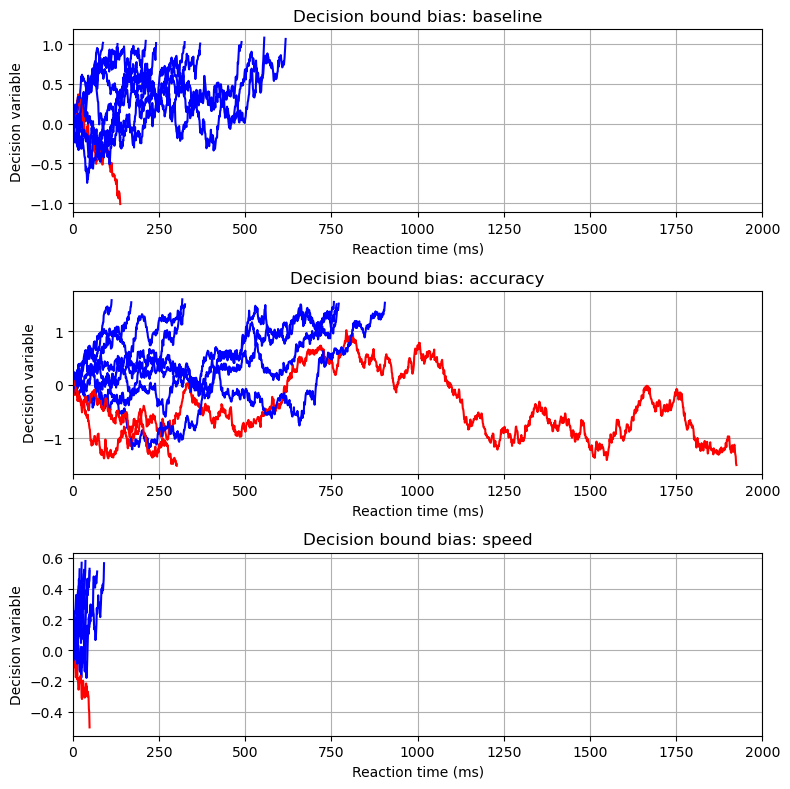

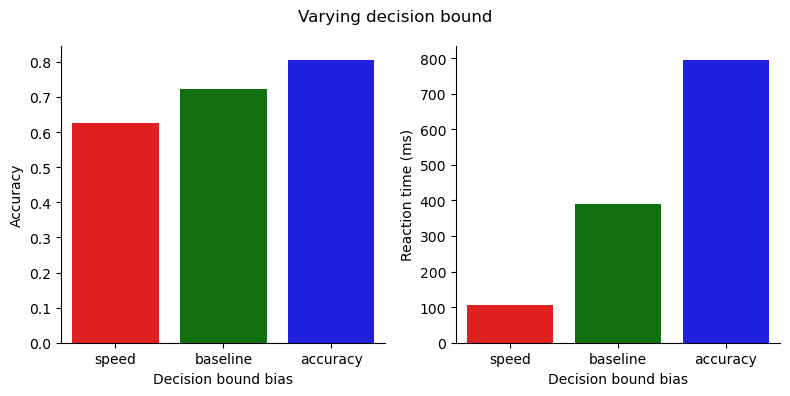

In [361]:
# Set a random seed
np.random.seed(1312)

# Set up different models:
C0, v, dt, w, B = 0., 2.5, 5e-4, .05, 1.
Bs = [1., 1.5, 0.5]
labels = ['baseline', 'accuracy', 'speed']

# Run models and plot for three evidence levels:
runs = [(label, *ddm(C0, v, dt, w, B)) for label, B in zip(labels, Bs) for _ in range(1000)]
df = pd.DataFrame(runs, columns=('label', 'C', 'z', 'x'))

plt.figure(figsize=(8, 8))
for j, label in enumerate(labels):
    plt.subplot(311 + j)
    for i in range(10):
        _, C, z, x = df[df.label == label].iloc[i]
        color = 'b' if float(C) > 0 else 'r'
        plt.plot(np.arange(z), x, color=color)
    plt.xlabel('Reaction time (ms)')
    plt.ylabel('Decision variable')
    plt.xlim(0, 2000)
    plt.title(f'Decision bound bias: {label}')
    plt.grid()
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 4))
plt.subplot(121)
acc_by_label = pd.DataFrame({'label': df.label, 'accuracy': df.C > 0.0}).groupby(['label'], as_index=False).mean()
sns.barplot(acc_by_label, x='label', y='accuracy', order=['speed', 'baseline', 'accuracy'], palette=['r', 'g', 'b'])
plt.xlabel('Decision bound bias')
plt.ylabel('Accuracy')
sns.despine()
plt.subplot(122)
rt_by_label = df[['label', 'z']].groupby('label', as_index=False).mean()
sns.barplot(rt_by_label, x='label', y='z', order=['speed', 'baseline', 'accuracy'], palette=['r', 'g', 'b'])
plt.xlabel('Decision bound bias')
plt.ylabel('Reaction time (ms)')
sns.despine()
plt.suptitle('Varying decision bound')
plt.tight_layout()
plt.show()

### Problem 4: Trial-by-trial sensory variability
In the original "baseline" model, we see that the reaction time distributions for correct and incorrect trials are largely overlapping. However, in experiments, reaction times for incorrect trials are typically longer than for correct trials. To capture this effect, let's add some trial-by-trial variability: instead of a fixed $v$ for all trials, allow $v$ to vary across trials according to a normal distribution $v = 2.5 + \mathcal{N}(0,5)$. Report the mean, median, and skew as in Problem 1.

_The mean and median reaction time for this model is faster for correct answers. Both distributions have a right skew._

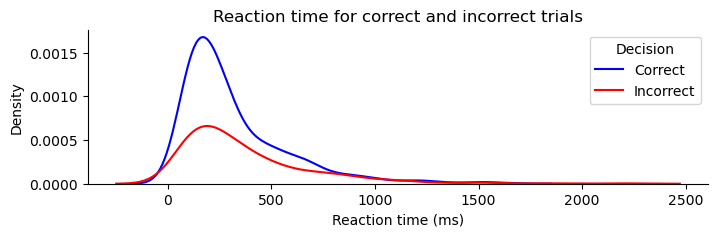

In [385]:
# Set a random seed
np.random.seed(1312)

# Run models with trial-by-trial variability:
C0, v, dt, w, B = 0., 2.5, 5e-4, .05, 1.

runs = [ddm(C0, 2.5 + np.random.randn() * 5, dt, w, B) for _ in range(1000)]
df = pd.DataFrame(runs, columns=('C', 'z', 'x'))

# Plot RT distributions of correct and incorrect trials:
plt.figure(figsize=(8, 2))
sns.kdeplot(df, x='z', hue='C', hue_order=[-1.0, 1.0], palette=['r', 'b'])
plt.xlabel('Reaction time (ms)')
plt.title('Reaction time for correct and incorrect trials')
plt.legend(title="Decision", labels=['Correct', 'Incorrect'])
sns.despine()
plt.show()

In [386]:
# Report the mean, median, and skew:
df[['C', 'z']].groupby('C').agg(['mean', 'median', skew])

z                 
            mean median      skew
C                                
-1.0  368.654070  269.5  1.997106
 1.0  316.539634  231.5  1.914055